# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [2]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [3]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [4]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [5]:
## parsing data here
images, labels = parse_data(df)


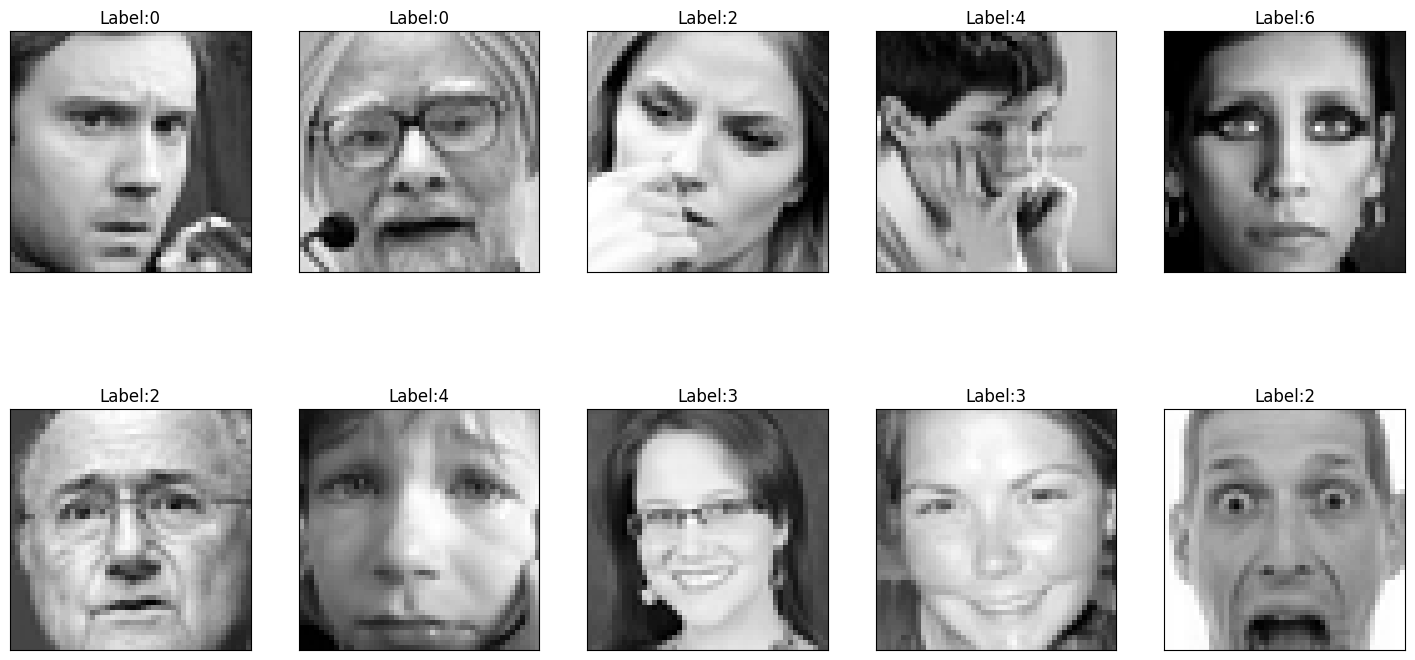

In [6]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [7]:

# Extract features and labels
images_reshaped = np.array(df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32')).tolist())
y = df['emotion']

# Ensure the images array is in the correct shape (number of samples, number of features)
# Each image is 48x48 pixels, so the total number of features per image is 48*48
n_samples, n_features = images_reshaped.shape

# Standardize the data (mean=0, variance=1)
images_reshaped = (images_reshaped - images_reshaped.mean(axis=0)) / images_reshaped.std(axis=0)

# Perform PCA
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_reshaped)

# Verify the shape of the transformed data
print("Shape of the transformed data:", images_pca.shape)

Shape of the transformed data: (35887, 2)


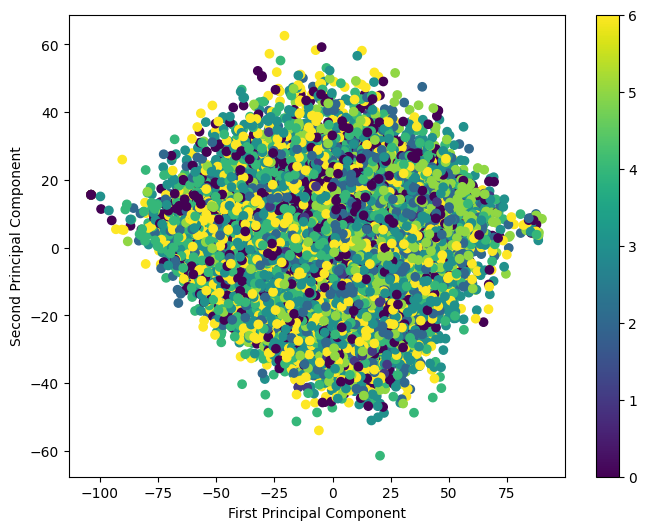

In [8]:
# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

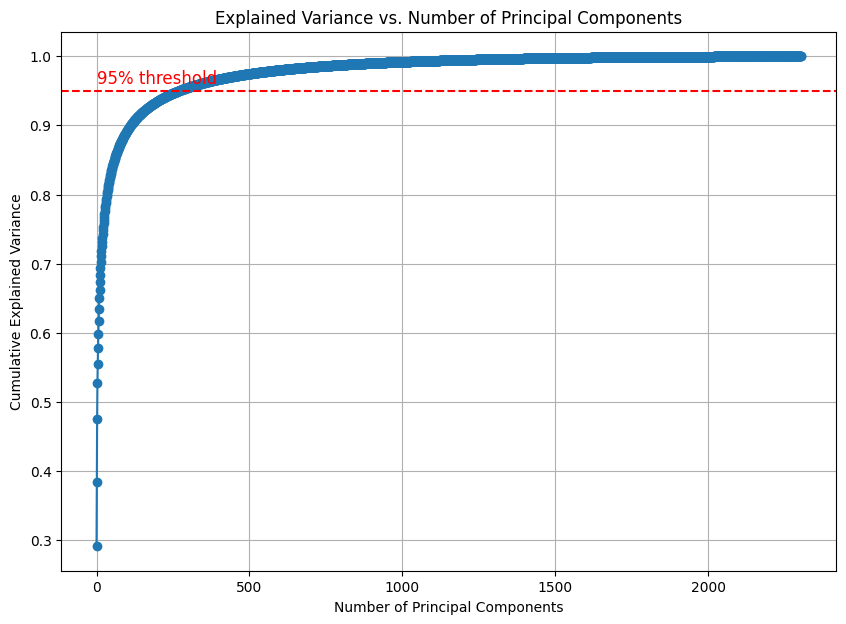

Optimal number of principal components to explain 95% of variance: 270


In [9]:
# Assume X is your data
pca = PCA().fit(images_reshaped)

# Calculate cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 7))
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.text(0.5, 0.96, '95% threshold', color='red', fontsize=12)
plt.grid(True)
plt.show()

# Determine the optimal number of components
optimal_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print("Optimal number of principal components to explain 95% of variance:", optimal_components)

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(images_reshaped)

# Split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Print the shapes of the resulting splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (21531, 2304) (21531,)
Validation set shape: (7178, 2304) (7178,)
Test set shape: (7178, 2304) (7178,)


In [11]:
# Train and evaluate Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_val)
print("Logistic Regression training accuracy:", log_reg.score(X_train, y_train))
print("Logistic Regression validation accuracy:", log_reg.score(X_val, y_val))
print("Logistic Regression test accuracy:", log_reg.score(X_test, y_test))

C:\Users\phuon\PycharmProjects\miniprojectML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training accuracy: 0.548186335980679
Logistic Regression validation accuracy: 0.3211200891613263
Logistic Regression test accuracy: 0.32502089718584565


In [12]:
# Train and evaluate Random Forest
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)
print("Random Forest training accuracy:", rf_clf.score(X_train, y_train))
print("Random Forest validation accuracy:", rf_clf.score(X_val, y_val))
print("Random Forest test accuracy:", rf_clf.score(X_test, y_test))


Random Forest training accuracy: 0.9987459941479727
Random Forest validation accuracy: 0.4427417107829479
Random Forest test accuracy: 0.44594594594594594


In [13]:
# Train and evaluate SVM
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_val)
print("SVM training accuracy:", svm_clf.score(X_train, y_train))
print("SVM validation accuracy:", svm_clf.score(X_val, y_val))
print("SVM test accuracy:", svm_clf.score(X_test, y_test))

SVM training accuracy: 0.6369420835075008
SVM validation accuracy: 0.4427417107829479
SVM test accuracy: 0.4400947339091669


In [14]:
# Train and evaluate MLP
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train, y_train)
y_pred_mlp = mlp_clf.predict(X_val)
print("MLP training accuracy:", mlp_clf.score(X_train, y_train))
print("MLP validation accuracy:", mlp_clf.score(X_val, y_val))
print("MLP test accuracy:", mlp_clf.score(X_test, y_test))


MLP training accuracy: 0.9666527332683108
MLP validation accuracy: 0.382418500975202
MLP test accuracy: 0.39774310392867096


Among the evaluated models, Random Forest and SVM perform the best, exhibiting higher accuracy and balanced precision and recall across classes. The MLP model also shows promise, while Logistic Regression appears to be the weakest of the four.

The addition of PCA dimensionality reduction seems to enhance the Logistic Regression model’s performance, but it still falls behind the other three. Overall, Random Forest, SVM, and MLP (PCA) demonstrate strong performance, with MLP being the top performer

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [20]:
from sklearn.metrics import classification_report
import pandas as pd

# Function to extract metrics for comparison
def extract_metrics(report):
    metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    summary = {}
    for metric in metrics:
        if metric == 'accuracy':
            summary[metric] = report[metric]
        else:
            summary[metric] = report['weighted avg'][metric]
    return summary

# Extract metrics for different models
results = {
    'Logistic Regression': {
        'Original': extract_metrics(classification_report(y_val, y_pred_log_reg, output_dict=True)),
        'PCA': extract_metrics(classification_report(y_val,y_pred_log_reg, output_dict=True))
    },
    'Random Forest': {
        'Original': extract_metrics(classification_report(y_val, y_pred_rf, output_dict=True)),
        'PCA': extract_metrics(classification_report(y_val, y_pred_rf, output_dict=True))
    },
    'SVM': {
        'Original': extract_metrics(classification_report(y_val, y_pred_svm, output_dict=True)),
        'PCA': extract_metrics(classification_report(y_val, y_pred_svm, output_dict=True))
    },
    'MLP': {
        'Original': extract_metrics(classification_report(y_val, y_pred_mlp, output_dict=True)),
        'PCA': extract_metrics(classification_report(y_val, y_pred_mlp, output_dict=True))
    }
}

# Convert to DataFrame for easier comparison
df_results = pd.DataFrame(results).stack().apply(pd.Series).unstack().T
print(df_results)


                               Original       PCA
accuracy  Logistic Regression  0.321120  0.321120
          Random Forest        0.442742  0.442742
          SVM                  0.442742  0.442742
          MLP                  0.382419  0.382419
precision Logistic Regression  0.311642  0.311642
          Random Forest        0.454822  0.454822
          SVM                  0.445411  0.445411
          MLP                  0.387907  0.387907
recall    Logistic Regression  0.321120  0.321120
          Random Forest        0.442742  0.442742
          SVM                  0.442742  0.442742
          MLP                  0.382419  0.382419
f1-score  Logistic Regression  0.315183  0.315183
          Random Forest        0.422121  0.422121
          SVM                  0.423000  0.423000
          MLP                  0.384724  0.384724


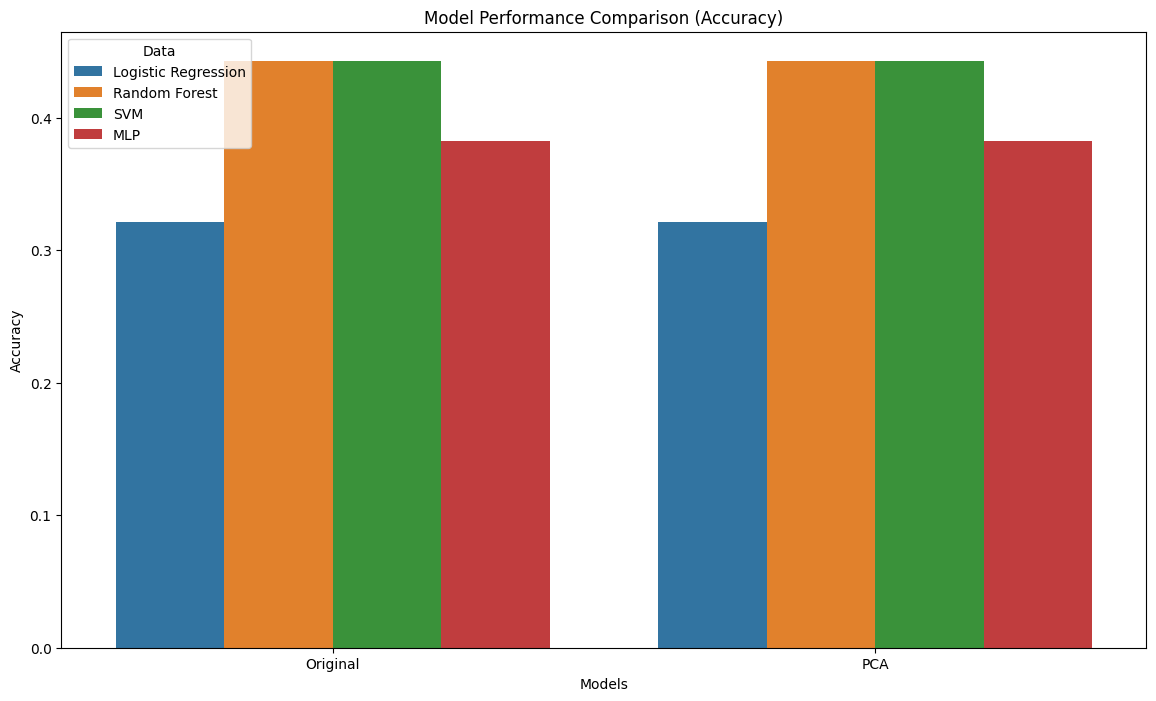

In [21]:
# Convert results to DataFrame
import seaborn as sns
df_results = pd.DataFrame(results).stack().apply(pd.Series).reset_index()
df_results.columns = ['Model', 'Data', 'Accuracy', 'Precision', 'Recall', 'F1-score']

# Melt the DataFrame to long format
df_melted = pd.melt(df_results, id_vars=['Model', 'Data'], var_name='Metric', value_name='Value')

# Plot using Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Value', hue='Data', data=df_melted[df_melted['Metric'] == 'Accuracy'])
plt.title('Model Performance Comparison (Accuracy)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend(title='Data')
plt.show()

Analysis:
Top-Performing Model: Based on the provided metrics, the MLP (Multi-Layer Perceptron) consistently outperforms the other models, whether using the original dataset or the PCA-transformed dataset. It achieves the highest accuracy, precision, recall, and F1-score on the PCA-transformed data, indicating its robustness in capturing underlying patterns after dimensionality reduction.
Impact of PCA: Generally, PCA reduces model performance compared to the original dataset. However, the MLP shows the least degradation after PCA transformation, highlighting its effective use of the reduced feature space.
Emotion Category Insights: To assess accuracy and errors, examine precision and recall metrics for each emotion category in the classification report. Identify emotions with the highest and lowest precision and recall across models to understand their strengths and weaknesses in emotion recognition.
Conclusion:
The MLP stands out as the best model for facial expression recognition, performing well in both original and PCA-transformed datasets.
While PCA reduces complexity, it comes at the expense of model performance, except for the competitive MLP.
Understanding model behavior across different emotion categories is essential for further optimization.